# FIAD | 2024| Project 1 

In [1]:
import numpy as np
import pandas as pd
import math
from math import sqrt, cos, sin, ceil
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error
from typing import Tuple

import imageio
from numpy.linalg import inv
import sys
sys.path.insert(0, 'Kalman-and-Bayesian-Filters-in-Python-master')
import kf_book.nonlinear_plots as nonlinear_plots
import kf_book.ekf_internal as ekf_internal
import kf_book.ukf_internal as ukf_internalß


# Introduction of the Problem

This project focuses on integrating sensor data fusion methods to enhance robot localization accuracy. The equipment comprises a speed sensor, a gyroscope, and a Global Navigation Satellite System (GNSS) sensor, we aim to optimize the fusion process for improved positioning precision. We will study and benchmark two different filters:
    <ul>
        <li> Extended Kalman Filter
        <li> Unscented Kalman Filter

### Dealing with non linearity
The simple Kalman filter relies on linear equations, making it unsuitable for handling nonlinear problems. Our robot's movement follows an elliptical trajectory, inherently nonlinear and incompatible with linear equations. The Extended Kalman Filter (EKF) doesn't modify the Kalman filter's linear equations directly. Instead, it linearizes the nonlinear equations around the current estimate point, incorporating this linearization into the Kalman filter framework. Linearization involves approximating the nonlinear curve with a line that closely matches its behavior at a specific point. We linearize systems by taking the derivative, which finds the slope of a curve [4].

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

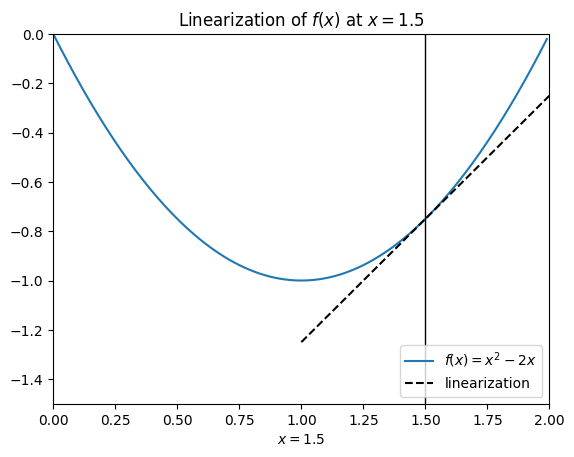

In [4]:
ekf_internal.show_linearization()

This process is a bit like zooming in on a curve and pretending it's a straight line for a small section. According to Labbe [6], we achieve this by calculating the partial derivatives of these functions at a particular point, which gives us matrices called Jacobians. These Jacobians help us build simplified versions of the original functions that are linear and easier to work with.

The differences from the linear filter:

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$



Formulas obtained from the book Kalman and Bayesian Filters in Python (Labbe, 2016) [6]

# 1. Criar uma função que implementa o modelo dinâmico do robot;

The state vector of our robot will be the following:

$$\mathbf X_k = \begin{bmatrix}\mathtt{x-position} \\\mathtt{y-position}\\ \mathtt{orientation} \\\mathtt{velocity}\end{bmatrix} = \begin{bmatrix}x_k \\ y_k \\ \phi_k \\ \nu_k\end{bmatrix}$$


The velocity sensor is denoted by $\nu$, and the gyroscope is $\omega$:
$$\mathbf U_k = \begin{bmatrix}\nu_k \\ \omega_k\end{bmatrix}$$


In [5]:
v = 1  # Velocidade linear (m/s)
w = 0.1  # Velocidade angular (rad/s)
dt = 0.1  # Intervalo de tempo (s)
k = 500 # Número de iterações

U = np.zeros((2, 1)) ** 2  # Control input
Q = np.diag([0.01, 0.01, np.deg2rad(1), 0.01]) ** 2
R = np.diag([0.45, 0.45]) ** 2

The non-linear dynamic model of the robot in the dynamic state space is given by:

$$\mathbf{x}_{k+1} =  \mathbf{A}x_k +  \mathbf{B}u_k + \mathbf{w}_k$$

In [6]:
def dynamic_model(x, U, w):
    A = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 0]])

    B = np.array([[dt * math.cos(x[2, 0]), 0],
                  [dt * math.sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    x = A.dot(x) + B.dot(U) + w

    return x

In [7]:
def jacobA(x, u):
    v = u[0, 0]
    phi = x[2, 0]
    
    jA = np.array([[1, 0, -v * np.sin(phi) * dt, np.cos(phi) * dt],
                   [0, 1, v * np.cos(phi) * dt, np.sin(phi) * dt],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]], dtype=float)
    
    return jA

# 2. Criar uma função que implementa o modelo de observação;

The non-linear dynamic model of the robot in the dynamic state space is given by:

$$\mathbf{z}_{k} =  \mathbf{C}x_k +  \mathbf{r}k

In [8]:
def observation_model(x,r):
    #  Observation Model
    C = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]])

    z = C.dot(x) + r

    return z

In [9]:
def jacobC():
    jC = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0]], dtype=float)

    return jC

# 3. Criar uma função que representa a aquisição de dados dos sensores;

The robot also has a GNSS, which allows us to track the $x$ and $y$ position at each k instance:

$$\mathbf Z_k = \begin{bmatrix}x_k \\ y_k \end{bmatrix}$$

The robot model can be represented by:
$$\begin{aligned}\dot \phi = \omega\\\
\end{aligned}$$



In [10]:
def get_gnss_values(trajectory, noise_scale):
    # Create the GNSS readings by adding noise to the trajectory
    noise = np.random.normal(scale=noise_scale, size=trajectory.shape)
    gnss_readings = trajectory + noise

    return gnss_readings

def get_gyroscope_values(v, w, delta_t, num_iterations, gaussian_noise_scale=0.09, drift_scale=0.0005, fail_probability=0.01):
    time_steps = np.arange(num_iterations) * delta_t
    gaussian_noise_v = np.random.normal(scale=gaussian_noise_scale, size=num_iterations)
    gaussian_noise_w = np.random.normal(scale=gaussian_noise_scale, size=num_iterations)
    drift_v = np.cumsum(np.random.normal(scale=drift_scale, size=num_iterations))
    drift_w = np.cumsum(np.random.normal(scale=drift_scale, size=num_iterations))
    v_values = v + gaussian_noise_v + drift_v
    w_values = w + gaussian_noise_w + drift_w

    # Simulate sensor failure
    fail_indices = np.random.rand(num_iterations) < fail_probability
    v_values[fail_indices] = 0
    w_values[fail_indices] = 0

    return v_values, w_values

For the gyroscope sensor, we added several different types of noise to introduce more realism and robustness into our model, making our dead reckoning closer to real-world problems such as sensor failures, inaccuracies, and small noises.

gaussian_noise_scale=0.09,
drift_scale=0.0005,
fail_probability=0.01

In [11]:
def simulate_circular_trajectory(v, w, delta_t, num_iterations):
    # Initial conditions
    x = 0  # Initial position in x
    y = 0  # Initial position in y
    theta = 0  # Initial angle

    # 2D array to store the coordinates
    coordinates = np.zeros((num_iterations, 2))

    # Simulate the circular trajectory
    for i in range(num_iterations):
        x += v * np.cos(theta) * delta_t
        y += v * np.sin(theta) * delta_t
        theta += w * delta_t

        coordinates[i] = [x, y]
    return coordinates


# 4. Criar uma função que implementa o Extended Kalman Filter (EKF);

We will use $\sigma_{}= 2,5$ departures from the mean for the noise of the input sensors. This gives us:
$$\mathbf R = \begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{range}^2\end{bmatrix} = \begin{bmatrix}2.5 & 0 \\ 0 & 2.5\end{bmatrix}$$

The Q matrix in the Extended Kalman Filter (EKF) balances trust between the prediction model and measurements. Higher Q values indicate more uncertainty in the model, causing the filter to rely more on measurements. In this project, higher Q values led to excessive trust in noisy GPS data, resembling overfitting. Lower Q values (e.g., 0.001) prioritize trust in the model, mitigating overfitting and improving state estimation accuracy.
$$\mathbf Q = \begin{bmatrix}0.001 & 0 & 0 & 0 \\ 0 & 0.001 & 0 & 0 \\ 0 & 0 & 0.001 & 0 \\ 0 & 0 & 0 & 0.001\end{bmatrix}$$

In [12]:
def dead_reckoning(v_values, w_values, dt, k):
    # Initialize the positions and orientations
    positions = np.zeros((k, 2))
    orientations = np.zeros(k)

    # Iterate over the number of steps
    for i in range(1, k):
        # Calculate the change in position and orientation
        dx = v_values[i] * np.cos(orientations[i-1]) * dt
        dy = v_values[i] * np.sin(orientations[i-1]) * dt
        dtheta = w_values[i] * dt

        # Update the current position and orientation
        positions[i] = positions[i-1] + np.array([dx, dy])
        orientations[i] = orientations[i-1] + dtheta

    return positions, orientations

In [13]:
def extended_kalman_filter(x_est, P_est, z, U, Q, R, dt, dynamic_model, observation_model, jacobA, jacobC):
    # Prediction Step
    # Predict next state using dynamic model
    x_pred = dynamic_model(x_est, U, np.zeros((4, 1)))
    # Compute Jacobian of dynamic model
    F = jacobA(x_pred, U)
    # Predict next covariance
    P_pred = F.dot(P_est).dot(F.T) + Q
    
    # Update Step
    # Compute Kalman Gain
    H = jacobC()
    K = P_pred.dot(H.T).dot(np.linalg.inv(H.dot(P_pred).dot(H.T) + R))
    # Update state estimate
    x_est = x_pred + K.dot(z - observation_model(x_pred, np.zeros((2, 1))))
    # Update covariance
    P_est = (np.eye(4) - K.dot(H)).dot(P_pred)
    
    return x_est, P_est


The Kalman gain quantifies the adjustment needed in the next iteration for the predicted state based on the disparity between the predicted and actual measurements. Kalman gain is the following:

$$\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf{R})^{-1}$$


To ensure compatibility with the Kalman filter algorithm, we linearize the relationship between the state variables and the measurements using the Jacobian matrix H. Can be represented as:

$$H = \begin{bmatrix}
    \frac{\partial \nu}{\partial X} & \frac{\partial \nu}{\partial Y} & \frac{\partial \nu}{\partial \Phi} & \frac{\partial \nu}{\partial \nu} \\
    \frac{\partial \omega}{\partial X} & \frac{\partial \omega}{\partial Y} & \frac{\partial \omega}{\partial \Phi} & \frac{\partial \omega}{\partial \nu}
\end{bmatrix}$$

In [ ]:
# Load or generate trajectory data
trajectory = np.load('coordinates2.npy')

positions = np.load('dead_reckoning.npy')

# GPS data
gnss_measurements = get_gnss_values(trajectory, noise_scale=0.3) 

#estimate the initial state
estimated_states = np.zeros((k, 8)) 
x_est = np.zeros((4, 1))  # Initial state estimate
P_est = np.eye(4)  # Initial covariance matrix

#Iterate the Kalman Filter
for i in range(k):
    x_est, P_est = extended_kalman_filter(x_est, P_est, gnss_measurements[i], U, Q, R, dt, dynamic_model, observation_model, jacobA, jacobC)
    estimated_states[i] = x_est.flatten()

# Plot the true trajectory
plt.figure(figsize=(7, 7))
plt.plot(trajectory[:, 0], trajectory[:, 1], color='b', label='True trajectory')

# Plot the Kalman estimated states
plt.plot(estimated_states[:, 0], estimated_states[:, 1], color='r', label='Estimated states')

# Plot the G*GPS measurements
plt.scatter(gnss_measurements[:, 0], gnss_measurements[:, 1], color='g', s=6, label='GNSS measurements')

# Plot the dead reckoning positions
plt.plot(positions[:, 0], positions[:, 1], color='black', label='Dead reckoning')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Extended Kalman Filter')
plt.legend(loc='lower left', fontsize=8)
plt.grid(True)
plt.axis('equal')
plt.show()

![title](GIFS/ekf.gif)

# Benchmark

In [15]:
# Prepare a list to store all DataFrames
df_list = []

# Simulate 100 EKF trajectories
for j in range(100):
    # estimate the initial state
    estimated_states = np.zeros((k, 8)) 
    x_est = np.zeros((4, 1))  # Initial state estimate
    P_est = np.eye(4)  # Initial covariance matrix

    # Iterate the Kalman Filter
    for i in range(k):
        x_est, P_est = extended_kalman_filter(x_est, P_est, gnss_measurements[i], U, Q, R, dt, dynamic_model, observation_model, jacobA, jacobC)
        estimated_states[i] = x_est.flatten()
        
    # Add X and Y values together and store in a single column for each iteration
    df_temp = pd.DataFrame({f'iteration_{j}': estimated_states[:, 0] + estimated_states[:, 1]})
    df_list.append(df_temp)

# Add real_traj column
df_real_traj = pd.DataFrame({'real_traj': trajectory[:, 0] + trajectory[:, 1]})
df_list.append(df_real_traj)

# Concatenate all DataFrames in the list
df = pd.concat(df_list, axis=1)

$$\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ((x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2)}$$

In [18]:
# Calculate the square of the difference between each iteration and 'real_traj' for each row
df_sq_diff = (df.iloc[:, 0:100] - df['real_traj'].values.reshape(-1, 1))**2

# Calculate the mean of the squared differences for each row
mean_sq_diff = df_sq_diff.mean(axis=1)

# Create a copy of the DataFrame to avoid fragmentation
df_copy = df.copy()

# Calculate the square root of the mean squared differences for each row and add to the copied DataFrame
df_copy['rmse'] = np.sqrt(mean_sq_diff)

#adjust matrix dimensionality
estimated_states = estimated_states[:,:2]

# Calculate the squared errors for each pair of points
squared_errors = np.sum((trajectory - estimated_states)**2, axis=1)

# Calculate the mean of the squared errors
mean_squared_error = np.mean(squared_errors)

# Take the square root to get the RMSE
rmse = np.sqrt(mean_squared_error)

print(f"Total RMSE  x and y combined: {rmse}")

df_copy.head()

Total RMSE  x and y combined: 1.2707152678576092


,iteration_0,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,...,iteration_92,iteration_93,iteration_94,iteration_95,iteration_96,iteration_97,iteration_98,iteration_99,real_traj,rmse
0,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,...,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.680281,0.100000,0.580281
1,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,...,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.545459,0.200995,0.344464
2,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,...,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.631755,0.302975,0.328780
3,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,...,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.713456,0.405929,0.307527
4,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,...,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.575378,0.509848,0.065530


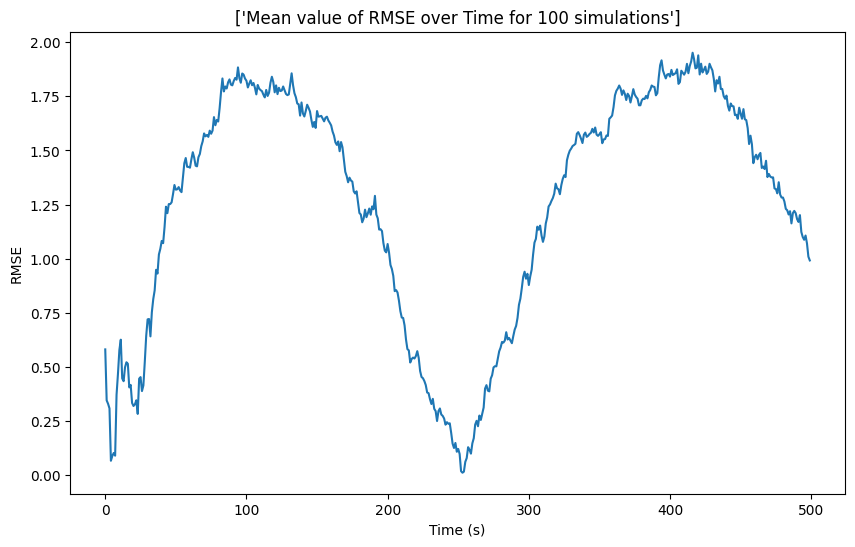

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(df_copy['rmse'])
plt.title(['Mean value of RMSE over Time for 100 simulations'])
plt.xlabel('Time (s)')
plt.ylabel('RMSE')
plt.show()

# 5. Criar uma função que implementa o Unscented Kalman Filter (UKF);

The UKF addresses non-linearity by approximating the propagation of mean and covariance through a nonlinear function. Unlike the EKF, which relies on linearization via matrices derivations, the UKF doesn't directly sample data from the function itself [2].

The Unscented Transform uses sigma points sampled from a Gaussian distribution to approximate the propagation of mean and covariance through a nonlinear function (shares similarities with monte carlo simulation). This concept illustrates how we can always aproximate a nonlinear function with enough sigma points, thus implementing a nonlinear Kalman filter effectively.

In [23]:
# initial parameters
alpha = 0.1 #control the spread of sigma points
beta = 2 #incorporates prior knowledge of the distribution of the state
kapa = 0 #control weighting of the sigma points

#  Simulation params
gps_noise = np.diag([0.3, 0.3])**2
input_noise = np.diag([0.9, np.deg2rad(1.0)])**2


In [24]:
def U(v=1.0, w=0.1):
    #robot sensor inputs
    return np.array([[v, w]]).T

In [25]:
def motion_model(x, U, dt=0.1):
    #Returns the predicted state vector at time t+1 using the dynamic model.
    F = np.identity(4, dtype=float)
    F[3, 3] = 0
    
    B = np.array([[dt * cos(x[2, 0]), 0],
                  [dt * sin(x[2, 0]), 0],
                  [0.0, dt],
                  [1.0, 0.0]])

    return F.dot(x) + B.dot(U)

In [26]:
def jacobH():
    #Returns the Jacobian matrix for the GPS observation model.
    return np.identity(4)[0:2]

In [27]:
def observation(x, sds, U):
    # Predict next state using motion model
    x = motion_model(x, U)

    # Generate noisy GPS observation
    real_obs = jacobH().dot(x) + gps_noise.dot(np.random.randn(2, 1))

    # Generate noise in the sensors inputs
    u_n = U + input_noise.dot(np.random.randn(2, 1))

    # Update dead reckoning estimate using motion model and noisy control input
    sds = motion_model(sds, u_n)

    return x, real_obs, sds, u_n

$$\begin{aligned}
\mathcal{X}_0 &= \mu\\
\mathcal{X}_i &= \mu \pm \sqrt{(n+\lambda)\Sigma}
\end{aligned}$$

## Sigma Points


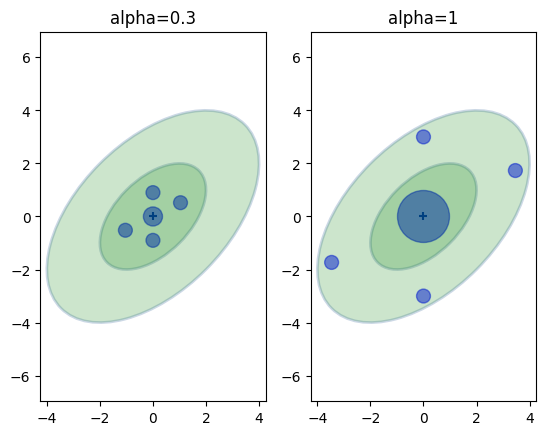

In [28]:
ukf_internal.plot_sigma_points()

The sigma points are positioned between the first and second standard deviations, a range commonly associated with capturing a significant portion of the distribution's dispersion. The parameter $\alpha$ controls the spread of these points, with larger values leading to wider dispersion. Moreover, higher $\alpha$ values assign greater weight to the mean (central point) and less weight to the surrounding points, aligning with the intuitive notion that points closer to the mean should be weighted more heavily.

To generate the first sigma point is the mean of the input (at the center of the eplisis).
The remaining sigma points are obtained by scaling the covariance matrix by a constant, take the square root and ensur symetry by adding and subtracting from the mean.


In [30]:
def generate_sigma_points(x, upd, sigma_scale):
    x_0 = x
    return np.concatenate((
        x_0,
        x_0 - sigma_scale * sqrtm(upd),
        x_0 + sigma_scale * sqrtm(upd)
    ), axis=1)


$$
\begin{cases}
\mathcal{X}_0 = \mu \\
\mathcal{X}_i = \mu +  \left[\sqrt{(n+\lambda)\Sigma} \right]_i, & i=1..n \\
\mathcal{X}_i = \mu - \left[\sqrt{(n+\lambda)\Sigma}\right]_{i-n} & i=(n+1)..2n
\end{cases}
$$

In [31]:
def calculate_sigma_cov(x, sigma_, w_Cov, pi):
    return w_Cov * (sigma_ - x) @ (sigma_ - x).T + pi


$$ 
\begin{aligned}
\text{sigmas} &= 
\begin{bmatrix}
\mathcal{X}_{0,0} & \mathcal{X}_{0,1} & \dots & \mathcal{X}_{0,n-1} \\
\mathcal{X}_{1,0} & \mathcal{X}_{1,1} &  \dots & \mathcal{X}_{1,n-1} \\
\vdots & \vdots &  \ddots & \vdots \\
\mathcal{X}_{2n,0} & \mathcal{X}_{2n,1} & \dots & \mathcal{X}_{2n,n-1}
\end{bmatrix}
\end{aligned}
$$


In [32]:
def calculate_cross_cov(sigma_, x, z_sigma, sigma_mean, w_Cov):
    return w_Cov * (sigma_ - x) @ (z_sigma - sigma_mean).T


Computing the cross covariance:
$$\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T$$


Comparing the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

In [33]:
def ukf_filter(
    state_estimate: np.ndarray, 
    covariance_estimate: np.ndarray, 
    actual_observation: np.ndarray, 
    control_input: np.ndarray, 
    weights_mean: np.ndarray, 
    weights_covariance: np.ndarray, 
    sigma_scale: float
) -> Tuple[np.ndarray, np.ndarray]:
    ## Predict Step:
    # Generate sigma points for state and covariance prediction
    sigma_points = generate_sigma_points(state_estimate, covariance_estimate, sigma_scale)
    
    # Propagate sigma points through the motion model to predict the next state
    propagated_sigma_points = motion_model(sigma_points, control_input)
    
    # Calculate predicted state by taking the weighted mean of propagated sigma points
    predicted_state = weights_mean @ propagated_sigma_points.T
    predicted_state = predicted_state.T
    
    # Calculate predicted covariance using propagated sigma points and weights
    predicted_covariance = calculate_sigma_cov(predicted_state, propagated_sigma_points, weights_covariance, Q)


    ## Update Step:
    # Predict the observation based on predicted state using measurement function jacobH
    predicted_observation = jacobH().dot(predicted_state)
    
    # Compute innovation (difference between actual observation and predicted observation)
    innovation = actual_observation - predicted_observation
    
    # Generate sigma points for predicted state and covariance using predicted state and covariance
    sigma_points = generate_sigma_points(predicted_state, predicted_covariance, sigma_scale)
    
    # Propagate sigma points through measurement function to obtain predicted observation sigma points
    observation_sigma_points = jacobH().dot(sigma_points)
    
    # Calculate mean of predicted observation using sigma points and weights
    observation_mean = weights_mean @ observation_sigma_points.T
    observation_mean = observation_mean.T
    
    # Calculate covariance of predicted observation using sigma points and weights
    observation_covariance = calculate_sigma_cov(observation_mean, observation_sigma_points, weights_covariance, R.T)
    
    # Calculate cross covariance between state and observation
    cross_covariance = calculate_cross_cov(sigma_points, predicted_state, observation_sigma_points, observation_mean, weights_covariance)
    
    # Compute Kalman gain
    kalman_gain = cross_covariance @ np.linalg.inv(observation_covariance.astype(float))
    
    # Update state estimate using predicted state, innovation, and Kalman gain
    state_estimate = predicted_state + kalman_gain @ innovation
    
    # Update covariance estimate using predicted covariance, observation covariance, and Kalman gain
    covariance_estimate = predicted_covariance - kalman_gain @ observation_covariance @ kalman_gain.T

    return state_estimate, covariance_estimate


### Weights


$$
\begin{aligned}
\lambda&=\alpha^2(n+\kappa)-n \\ 
W^m_0 &= \frac{\lambda}{n+\lambda} \\
W^c_0 &= \frac{\lambda}{n+\lambda} + 1 -\alpha^2 + \beta \\
W^m_i = W^c_i &= \frac{1}{2(n+\lambda)}\;\;\;i=1..2n
\end{aligned}
$$

In [34]:
def initialize_weights(L):
    # Calculate lambda parameter
    lambda_ = alpha ** 2 * (L + kapa) - L

    # Calculate initial weights for mean and covariance
    weights_mean = [lambda_ / (lambda_ + L)]  # Initial weight for mean
    w_Cov = [(lambda_ / (lambda_ + L)) + (1 - alpha ** 2 + beta)]  # Initial weight for covariance

    # Calculate weights for other sigma points
    const = 1.0 / (2 * (L + lambda_))
    for j in range(2 * L):
        weights_mean.append(const)  # Weight for mean
        w_Cov.append(const)  # Weight for covariance
    
    # Calculate sigma scale
    sigma_scale = sqrt(L + lambda_)

    return np.array([weights_mean]), np.array([w_Cov]), sigma_scale


In [ ]:
L = 4
x_pred = np.zeros((L, 1))
xtrue = np.zeros((L, 1))
pred_cov = np.eye(L)
weights_mean, w_Cov, sigma_scale = initialize_weights(L)
sds = np.zeros((L, 1))

# history 
predicted_history = x_pred
true_history = xtrue
deadreck2 = sds
measurement_hist = np.zeros((2, 1))
time = 0.0

for _ in range(k):
    time += dt 
    xtrue, real_obs, sds, u_n = observation(xtrue, sds, U())
    # Perform Unscented Kalman Filter prediction and update steps
    x_pred, pred_cov = ukf_filter(x_pred, pred_cov, real_obs, u_n, weights_mean, w_Cov, sigma_scale)
    # Store predicted state, true state, and sensor measurements
    predicted_history = np.hstack((predicted_history, x_pred))
    deadreck2 = np.hstack((deadreck2, sds))
    true_history = np.hstack((true_history, xtrue))
    measurement_hist = np.vstack((measurement_hist, real_obs))

plt.figure(figsize=(7, 7))
plt.cla()
plt.scatter(gnss_measurements[:, 0], gnss_measurements[:, 1], color='g', s=6, label='GNSS measurements')
plt.plot(true_history[0, :].flatten(), true_history[1, :].flatten(), "-b", label='True trajectory')
plt.plot(deadreck2[0, :].flatten(), deadreck2[1, :].flatten(), "-k", label='Dead reckoning')
plt.plot(predicted_history[0, :].flatten(), predicted_history[1, :].flatten(), "-r", label='Estimated states')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Unscented Kalman Filter')
plt.legend(loc='lower left', fontsize=8)
plt.grid(True)
plt.axis('equal')
plt.show()



![title](GIFS/UKF2.gif)

# Benchmark

In [39]:
# Initialize parameters
L = 4
weights_mean, w_Cov, sigma_scale = initialize_weights(L)
num_simulations = 100
num_time_steps = 500

# Initialize arrays to store predictions and real trajectories
predictions = np.zeros((num_time_steps, num_simulations))
real_trajectories = np.zeros(num_time_steps)

for j in range(num_simulations):
    x_pred = np.zeros((L, 1))
    xtrue = np.zeros((L, 1))
    pred_cov = np.eye(L)
    sds = np.zeros((L, 1))

    for i in range(num_time_steps):
        time += dt 
        xtrue, real_obs, sds, u_n = observation(xtrue, sds, U(1, 0.1))
        x_pred, pred_cov = ukf_filter(x_pred, pred_cov, real_obs, u_n, weights_mean, w_Cov, sigma_scale)
        predictions[i, j] = x_pred[0, -1] + x_pred[1, -1]
        if j == 0:  # Only need to calculate real trajectory once
            real_trajectories[i] = xtrue[0, -1] + xtrue[1, -1]

# Create DataFrame from predictions array
predicted_df = pd.DataFrame(predictions, columns=[f'iteration_{i}' for i in range(num_simulations)])

# Add real_traj column to DataFrame
predicted_df['real_traj'] = real_trajectories

# Calculate RMSE
predicted_df_sq_diff = (predicted_df.iloc[:, 0:num_simulations] - predicted_df['real_traj'].values.reshape(-1, 1))**2
mean_sq_diff = predicted_df_sq_diff.mean(axis=1)
predicted_df['rmse'] = np.sqrt(mean_sq_diff)

# Display the DataFrame
predicted_df.head()

,iteration_0,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,...,iteration_92,iteration_93,iteration_94,iteration_95,iteration_96,iteration_97,iteration_98,iteration_99,real_traj,rmse
0,0.071420,0.097443,0.100981,0.099238,0.319435,0.096490,0.117432,0.116944,-0.088577,-0.084675,...,0.061305,0.146595,0.137860,0.011601,-0.000886,0.205524,0.073332,0.024959,0.100000,0.097148
1,0.270569,0.118660,0.307685,0.231911,0.225344,0.170838,0.162231,0.201006,0.136654,0.110551,...,0.296011,0.289287,0.151237,0.100834,0.130796,0.171490,0.229159,0.094260,0.200995,0.085499
2,0.305122,0.259134,0.469044,0.389251,0.370463,0.277200,0.373737,0.321017,0.311127,0.179919,...,0.334670,0.391366,0.354114,0.311294,0.272890,0.226290,0.396407,0.222892,0.302975,0.093834
3,0.397503,0.405662,0.527683,0.431892,0.477050,0.260423,0.484808,0.469514,0.448807,0.197289,...,0.365789,0.420103,0.372010,0.497274,0.366666,0.255503,0.518863,0.244213,0.405929,0.105151
4,0.584732,0.516548,0.522098,0.629437,0.567908,0.420188,0.462957,0.642324,0.511272,0.371246,...,0.521575,0.325954,0.550922,0.559447,0.453146,0.403760,0.514650,0.431728,0.509848,0.109430


In [59]:
import plotly.graph_objects as go

# Calculate mean RMSE values
mean_rmse = df_copy['rmse'].mean()
mean_rmse2 = predicted_df['rmse'].mean()

# Create line plot for RMSE values
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_copy['rmse'], mode='lines', name='EKF_RMSE'))
fig.add_trace(go.Scatter(y=predicted_df['rmse'], mode='lines', name='UKF_RMSE'))

# Update layout for line plot
fig.update_layout(title='Comparison of EKF_RMSE and UKF_RMSE Means for 100 Simulations',
                  xaxis_title='Index',
                  yaxis_title='RMSE mean Value')

# Show line plot
fig.show()

# Create horizontal bar plot for mean RMSE values
fig = go.Figure(data=[go.Bar(y=['EKF_RMSE', 'UKF_RMSE'], x=[mean_rmse, mean_rmse2], orientation='h')])

# Update layout for bar plot
fig.update_layout(title='Comparison of EKF_RMSE and UKF_RMSE Means for 100 Simulations',
                  xaxis_title='RMSE mean Value')

# Show bar plot
fig.show()

# Discussion

In our problem, we decided to experiment with higher levels of noise than in real common situation ($\sigma$ = 0.3) to understand how well the filters performed when dealing with heightened uncertainty.

In the Extended Kalman Filter (EKF), we had to keep the Q value lower in order for our model to have confidence in its predictions rather than relying on the designed noisy inputs. This adjustment was necessary because we observed that the filter wasn't producing a smoother line and was overfitting the erroneous GPS data points. We noticed in our experiments that the EKF exhibited more lag compared to the Unscented Kalman Filter (UKF).

Our results are aligned with the literature, where UKF offered better performance than the EKF for our non-linear problem. We validate this hypothesis by calculating the RMSE for 100 simulations of each, and by far UFK scored a lower error. This results are easy to evident due to the nature of EKF linearly aproximating the problems with the jacobians and keep introducing small angular errors in a non linear trajectory. On the other hand, the UKF approximates the probability distribution through chosen sigma points.


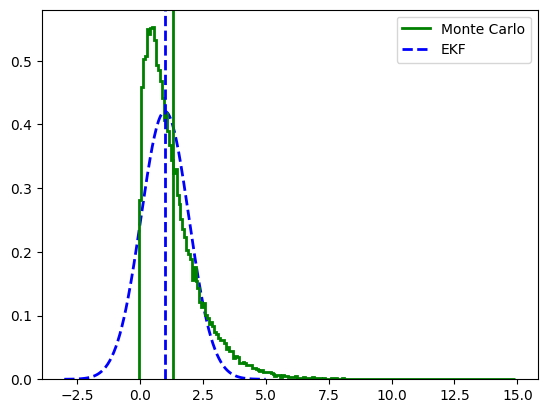

actual mean=1.30, std=1.14
EKF    mean=1.00, std=0.95


In [ ]:
nonlinear_plots.plot_ekf_vs_mc()

Based on the findings of this research [5], it appears that the EKF computation exhibits a significant level of inaccuracy, with the predicted mean of 1.00 differing notably from the actual mean of 1.30. In contrast, the Unscented Kalman Filter (UKF) demonstrates closer alignment with reality, with a predicted mean of 1.30 closely matching the actual mean of 1.31.


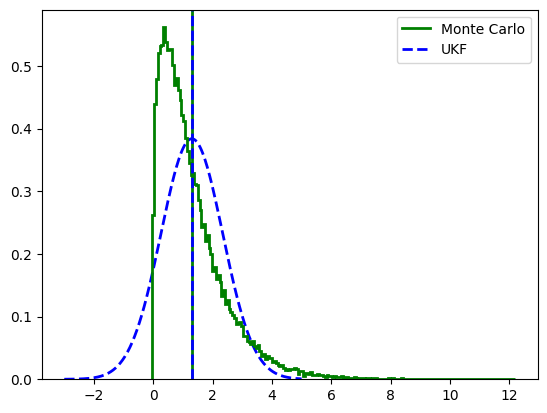

actual mean=1.31, std=1.13
UKF    mean=1.30, std=1.04


In [ ]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=2, kappa=0)

## References

In this study, insights regarding data fusion and analysis techniques were mainly derived from educational materials and guidance provided by Professors Alberto Cardoso and Miguel Fernandes during their classes.

Other References:

- [1] Rudolph Van der Merwe. "Sigma-Point Kalman Filters for Probabilistic Inference in Dynamic State-Space Models" dissertation (2004).

- [2] Simon J. Julier. "The Scaled Unscented Transformation". Proceedings of the American Control Conference 6. IEEE. (2002)

- [4] Julier, Simon J.; Uhlmann, Jeffrey "A New Extension of the Kalman  Filter to Nonlinear Systems". Proc. SPIE 3068, Signal Processing, Sensor Fusion, and Target Recognition VI, 182 (July 28, 1997)

- [5] Labbe, Roger. "Kalman and bayesian filters in python." Chap 7.246 (2014): 4.